# Slice large area in smaller bounding boxes and request a snapshot each

This script is partially based on: https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html

What this script does:
- Logs in to Sentinel Hub using the API credentials that can be found on your Sentinal account
- Load a json polygon from external source
- Use matplot lib to verify the correctness of the area
- Use SH utilities to split the area on several smaller bounding boxes
- Articulate a request for a single image for each of the smaller areas

Aditionally:
- Defines a time range
- Articulate multiple request for an area and download the images

### Import and configure Sentinel Hub API with credentials

In [1]:
# import config for Sentinel Hub API
from sentinelhub import SHConfig
# import personal config settings – keep them secret!
import sentinelconfig

config = SHConfig()
config.instance_id = sentinelconfig.instance
config.sh_client_id = sentinelconfig.client_ID
config.sh_client_secret = sentinelconfig.client_secret

# save current config settings
config.save()

# prompt warning if no credentials
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


### Import utilities

In [53]:
import os

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    read_data,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


# The following are not packages, but .py files in the same folder as this notebook.
# They contain functions to execute analysis tasks
from utils import show_area, show_splitter
from eval_img import evalscript_true_color

from shapely.geometry import MultiLineString, MultiPolygon, Polygon, shape
import numpy as np
import itertools
%matplotlib inline


### Import json file

The file has been generated in Google Earth. I will show you how to do it. You can also follow from step 6 on of this tutorial: https://www.mindat.org/a/geojson_from_google_earth

In [19]:
INPUT_FILE = "./aoi_atacama.json"

geo_json = read_data(INPUT_FILE)
atacama_area = shape(geo_json["features"][0]["geometry"])

type(atacama_area)


shapely.geometry.polygon.Polygon

### Plot and verify AOI

This function can be found in utils.py.
It plots the shapely geomtry to a map: useful to verify the correctness of the area you are using.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-70.20344230307033 -21.14590468414001


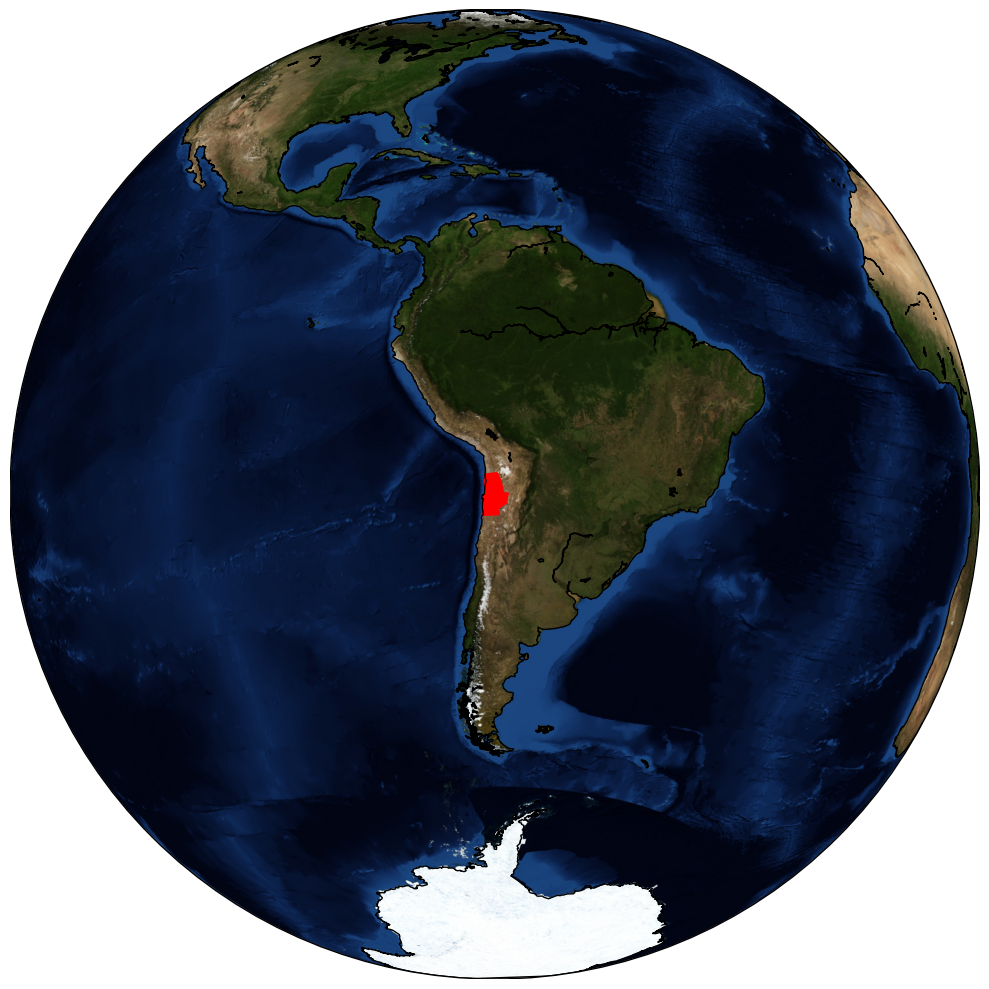

In [20]:
show_area(atacama_area)

### Create a splitter and verify its size

`BBoxSplitter` is part of the SentinelHub API package. It takes a large geo-referenced geometry (Polygon or MultiPolygon – hence non continuous features) and splits it into smaller bounding boxes based on a predefined grid. There are several ways of splitting a geometry, for example you can use the Open Street Map grid: https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html#Splitting-in-OSM-grid

We will use the most basic functionality offered by SH. Other info can be found here: https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.areas.html#sentinelhub.areas.BBoxSplitter

In [21]:
bbox_splitter = BBoxSplitter(
    # The splitter parameters are: the polygon, the CRS, and a tuple of columns and rows to split the polygon
    [atacama_area], CRS.WGS84, (5, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(
    bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-70.622131635392, -25.4766076549912), (-69.9434998799288, -24.218380549740303)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



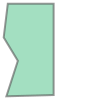

In [78]:
# We can verify the first element of our list

geometry_list = bbox_splitter.get_geometry_list()
geometry_list[0]

### Verify how many areas have been created by the splitter

Again, we use a function available in the `utils.py` file. This function allows you to plot the different rows and columns that have been created by the splitter

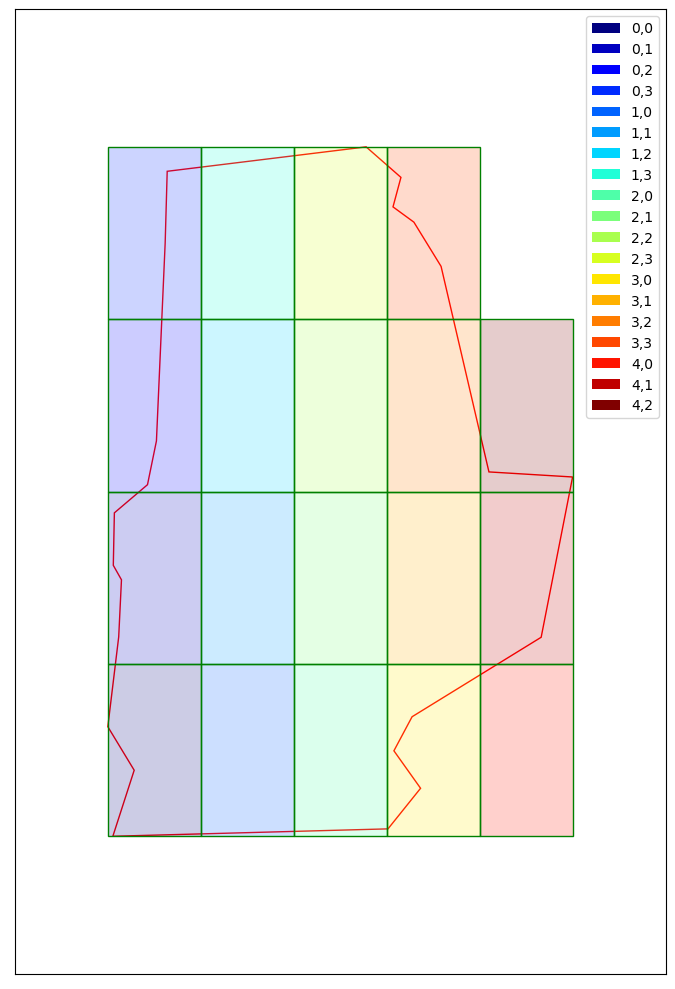

In [24]:
show_splitter(bbox_splitter, show_legend=True)

### Reduced and granular BBox Split? Yes please!

Among other parameters, `BBoxSplitter` takes `reduce_bbox_sizes`. This boolean (True/False) lets you determine if you want to crop your AOI boundaries more precisely. In this example we also make the grid more granular (6x6).

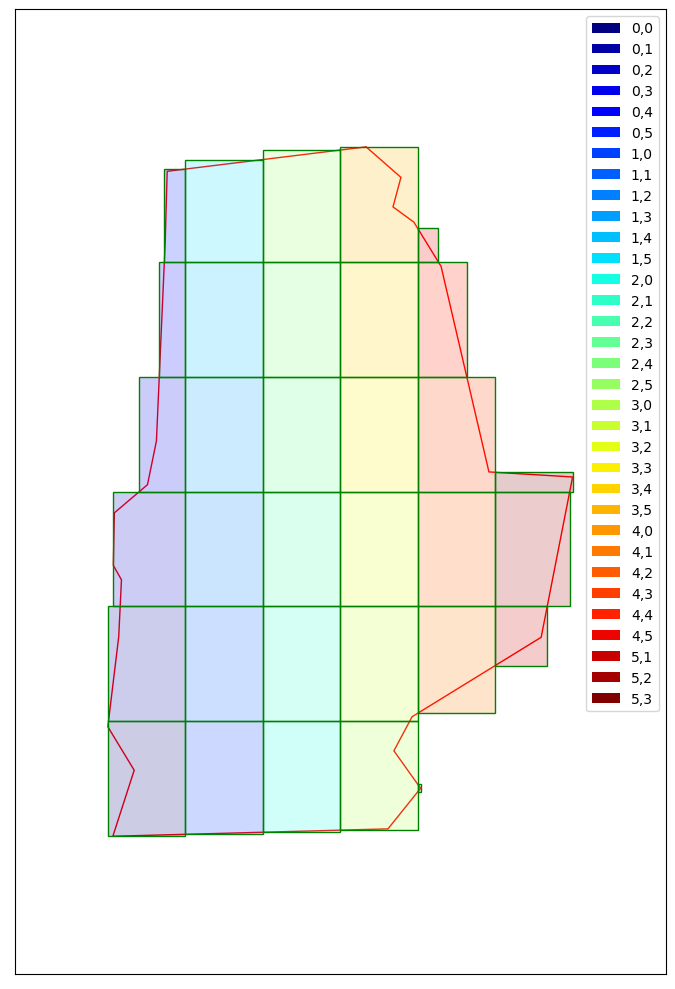

nbbox: BBox(((-70.622131635392, -25.4766076549912), (-70.056605172506, -24.637789584823935)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-70.622131635392, -25.4766076549912), (-67.22897285807598, -20.44369923398761)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



In [40]:
bbox_splitter_reduced = BBoxSplitter(
    [atacama_area], CRS.WGS84, (6, 6), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

bbox_red_list = bbox_splitter_reduced.get_bbox_list()
info_red_list = bbox_splitter_reduced.get_info_list()
print(bbox_splitter_reduced)
print("nbbox: {}\ninfo: {}\n".format(
    bbox_red_list[0].__repr__(), info_red_list[0]
))


### Define request and iterate over bounding boxes

This approach combines some functions and methods from previous examples. We define a function for the request including the data folder for export, the data collection, the time interval, the type of export (`MimeType.TIFF`), bbox and area size. These last two variables are parameters of our function, this way we can iterate over our list and pass each bounding box to the API independently.

In [79]:
def get_true_color_request(bbox_area, area_size):
    return SentinelHubRequest(
        data_folder="request_output/area_segmentation",
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=("2020-12-01", "2020-12-31"),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response(
            # There are several types of export, but Tiff allows us to create a georeferenced image!
            "default", MimeType.TIFF)],
        bbox=bbox_area,
        size=area_size,
        config=config,
    )


Here's where the magic happens. Now that we made sure our area is correct and we splitted it in several smaller chunks, we can iterate over the list of bbox coordinates and request a scene for each one of it.

In [80]:

# Iterate over the splitter list of bboxes
for list_el in bbox_splitter_reduced.get_bbox_list():
    print(list_el)

    # WGS84 coords for Area Of Interest (AOI)
    # Instead of giving only one area of interest, we provide the current bounding box
    area_wgs84 = list_el

    # Same as before, define resolution, bbox, and size
    resolution = 60
    atacama_bbox = BBox(bbox=area_wgs84, crs=CRS.WGS84)
    atacama_size = bbox_to_dimensions(atacama_bbox, resolution=resolution)

    print(f"Image shape at {resolution} m resolution: {atacama_size} pixels")
    # Create request and download list, then pass configuration data and download img
    request = get_true_color_request(atacama_bbox, atacama_size)
    download_list = request.download_list[0]
    data = SentinelHubDownloadClient(config=config).download(
        download_list, show_progress=True)
    
    # Saves image at folder
    for folder, _, filenames in os.walk(get_true_color_request(atacama_bbox, atacama_size).data_folder):
        for filename in filenames:
            print(f"Image with resolution: {atacama_size} pixels, for bbox: {list_el} saved at {folder}")


-70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935
Image shape at 60 m resolution: (935, 1558) pixels


  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at request_output
Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at request_output
Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at request_output/area_segmentation
Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (935, 1558) pixels, for bbox: -70.622131635392,-25.4766076549912,-70.056605172506,-24.637789584823935 saved at r

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667 saved at request_output
Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667 saved at request_output
Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (934, 1557) pixels, for bbox: -70.61739920092589,-24.637789584823935,-70.056605172506,-23.79

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404 saved at request_output
Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404 saved at request_output
Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (881, 1556) pixels, for bbox: -70.58206836611468,-23.798971514656667,-70.056605172506,-22.96

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214 saved at request_output
Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214 saved at request_output
Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214 saved at request_output/area_segmentation
Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (561, 1552) pixels, for bbox: -70.3915236908232,-22.960153444489404,-70.056605172506,-22.1213353743221

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872 saved at request_output
Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872 saved at request_output
Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872 saved at request_output/area_segmentation
Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (316, 1550) pixels, for bbox: -70.24650110676366,-22.12133537432214,-70.056605172506,-21.28251730

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156 saved at request_output
Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156 saved at request_output
Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156 saved at request_output/area_segmentation
Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.605737626400156 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (256, 1250) pixels, for bbox: -70.20947284531844,-21.282517304154872,-70.056605172506,-20.60

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.637789584823935 saved at request_output
Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.637789584823935 saved at request_output
Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.637789584823935 saved at request_output/area_segmentation
Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (942, 1527) pixels, for bbox: -70.056605172506,-25.462399896644044,-69.49107870961998,-24.63

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.798971514656667 saved at request_output
Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.798971514656667 saved at request_output
Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (949, 1553) pixels, for bbox: -70.056605172506,-24.637789584823935,-69.49107870961998,-23.79

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.960153444489404 saved at request_output
Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.960153444489404 saved at request_output
Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1553) pixels, for bbox: -70.056605172506,-23.798971514656667,-69.49107870961998,-22.96

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.12133537432214 saved at request_output
Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.12133537432214 saved at request_output
Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.12133537432214 saved at request_output/area_segmentation
Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1553) pixels, for bbox: -70.056605172506,-22.960153444489404,-69.49107870961998,-22.1213353

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.282517304154872 saved at request_output
Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.282517304154872 saved at request_output
Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.282517304154872 saved at request_output/area_segmentation
Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1552) pixels, for bbox: -70.056605172506,-22.12133537432214,-69.49107870961998,-21.28251730

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.536335531541717 saved at request_output
Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.536335531541717 saved at request_output
Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.536335531541717 saved at request_output/area_segmentation
Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.536335531541717 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.536335531541717 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (974, 1381) pixels, for bbox: -70.056605172506,-21.282517304154872,-69.49107870961998,-20.53

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,-24.637789584823935 saved at request_output
Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,-24.637789584823935 saved at request_output
Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,-24.637789584823935 saved at request_output/area_segmentation
Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (948, 1495) pixels, for bbox: -69.49107870961998,-25.44720404121359,-68.92555224673399,

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.92555224673399,-23.798971514656667 saved at request_output
Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.92555224673399,-23.798971514656667 saved at request_output
Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.92555224673399,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.92555224673399,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.92555224673399,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1549) pixels, for bbox: -69.49107870961998,-24.637789584823935,-68.925552246

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.92555224673399,-22.960153444489404 saved at request_output
Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.92555224673399,-22.960153444489404 saved at request_output
Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.92555224673399,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.92555224673399,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.92555224673399,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1549) pixels, for bbox: -69.49107870961998,-23.798971514656667,-68.925552246

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399,-22.12133537432214 saved at request_output
Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399,-22.12133537432214 saved at request_output
Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399,-22.12133537432214 saved at request_output/area_segmentation
Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1549) pixels, for bbox: -69.49107870961998,-22.960153444489404,-68.92555224673399

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,-21.282517304154872 saved at request_output
Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,-21.282517304154872 saved at request_output
Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,-21.282517304154872 saved at request_output/area_segmentation
Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1549) pixels, for bbox: -69.49107870961998,-22.12133537432214,-68.92555224673399,

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399,-20.46693343668328 saved at request_output
Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399,-20.46693343668328 saved at request_output
Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399,-20.46693343668328 saved at request_output/area_segmentation
Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399,-20.46693343668328 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399,-20.46693343668328 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (978, 1506) pixels, for bbox: -69.49107870961998,-21.282517304154872,-68.92555224673399

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.36002578384799,-24.637789584823935 saved at request_output
Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.36002578384799,-24.637789584823935 saved at request_output
Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.36002578384799,-24.637789584823935 saved at request_output/area_segmentation
Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.36002578384799,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.36002578384799,-24.637789584823935 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (955, 1463) pixels, for bbox: -68.92555224673399,-25.432008185783136,-68.360025783

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.36002578384799,-23.798971514656667 saved at request_output
Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.36002578384799,-23.798971514656667 saved at request_output
Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.36002578384799,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.36002578384799,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.36002578384799,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (961, 1545) pixels, for bbox: -68.92555224673399,-24.637789584823935,-68.360025783

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.36002578384799,-22.960153444489404 saved at request_output
Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.36002578384799,-22.960153444489404 saved at request_output
Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.36002578384799,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.36002578384799,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.36002578384799,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1545) pixels, for bbox: -68.92555224673399,-23.798971514656667,-68.360025783

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799,-22.12133537432214 saved at request_output
Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799,-22.12133537432214 saved at request_output
Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799,-22.12133537432214 saved at request_output/area_segmentation
Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1545) pixels, for bbox: -68.92555224673399,-22.960153444489404,-68.36002578384799

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,-21.282517304154872 saved at request_output
Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,-21.282517304154872 saved at request_output
Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,-21.282517304154872 saved at request_output/area_segmentation
Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (978, 1545) pixels, for bbox: -68.92555224673399,-22.12133537432214,-68.36002578384799,

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799,-20.44369923398761 saved at request_output
Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799,-20.44369923398761 saved at request_output
Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799,-20.44369923398761 saved at request_output/area_segmentation
Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799,-20.44369923398761 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799,-20.44369923398761 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (984, 1545) pixels, for bbox: -68.92555224673399,-21.282517304154872,-68.36002578384799

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.096513354858466 saved at request_output
Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.096513354858466 saved at request_output
Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.096513354858466 saved at request_output/area_segmentation
Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.096513354858466 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.096513354858466 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (36, 103) pixels, for bbox: -68.36002578384799,-25.152678345093438,-68.33884162052176,-25.09

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.79449932096198,-23.798971514656667 saved at request_output
Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.79449932096198,-23.798971514656667 saved at request_output
Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.79449932096198,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.79449932096198,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.79449932096198,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (967, 1433) pixels, for bbox: -68.36002578384799,-24.578914267788473,-67.794499320

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.79449932096198,-22.960153444489404 saved at request_output
Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.79449932096198,-22.960153444489404 saved at request_output
Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.79449932096198,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.79449932096198,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.79449932096198,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (973, 1542) pixels, for bbox: -68.36002578384799,-23.798971514656667,-67.794499320

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198,-22.12133537432214 saved at request_output
Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198,-22.12133537432214 saved at request_output
Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198,-22.12133537432214 saved at request_output/area_segmentation
Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198,-22.12133537432214 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (979, 1542) pixels, for bbox: -68.36002578384799,-22.960153444489404,-67.79449932096198

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,-21.282517304154872 saved at request_output
Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,-21.282517304154872 saved at request_output
Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,-21.282517304154872 saved at request_output/area_segmentation
Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,-21.282517304154872 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (626, 1544) pixels, for bbox: -68.36002578384799,-22.12133537432214,-68.00164615048834,

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.03816888109518 saved at request_output
Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.03816888109518 saved at request_output
Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.03816888109518 saved at request_output/area_segmentation
Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.03816888109518 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.03816888109518 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (262, 450) pixels, for bbox: -68.36002578384799,-21.282517304154872,-68.20978135207626,-21.0

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,-23.798971514656667 saved at request_output
Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,-23.798971514656667 saved at request_output
Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,-23.798971514656667 saved at request_output/area_segmentation
Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,-23.798971514656667 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (652, 790) pixels, for bbox: -67.79449932096198,-24.230735314288964,-67.41433184293514,

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.24985169478146,-22.960153444489404 saved at request_output
Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.24985169478146,-22.960153444489404 saved at request_output
Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.24985169478146,-22.960153444489404 saved at request_output/area_segmentation
Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.24985169478146,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.24985169478146,-22.960153444489404 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (944, 1539) pixels, for bbox: -67.79449932096198,-23.798971514656667,-67.249851694

  0%|          | 0/1 [00:00<?, ?it/s]

Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,-22.819437248595772 saved at request_output
Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,-22.819437248595772 saved at request_output
Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,-22.819437248595772 saved at request_output/area_segmentation
Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,-22.819437248595772 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,-22.819437248595772 saved at request_output/area_segmentation/adc34e4272d2138753a524bcadfc530b
Image with resolution: (970, 250) pixels, for bbox: -67.79449932096198,-22.960153444489404,-67.22897285807598,